In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Set the path to the dataset
dataset_path_train = 'train_dataset_path'

# Get all class labels and their corresponding image paths
class_labels_train = []
for item_train in os.listdir(dataset_path_train):
    all_classes_train = os.listdir(os.path.join(dataset_path_train, item_train))
    for room_train in all_classes_train:
        class_labels_train.append((item_train, os.path.join(dataset_path_train, item_train, room_train)))

# Build a dataframe
df_train = pd.DataFrame(data=class_labels_train, columns=['Labels', 'image'])
label_count_train = df_train['Labels'].value_counts()

In [3]:
# Load and preprocess the images
im_size = 384
images_train = []
labels_train = []
for index_train, row_train in df_train.iterrows():
    img_train = cv2.imread(row_train['image'])
    img_train = cv2.resize(img_train, (im_size, im_size))
    images_train.append(img_train)
    labels_train.append(row_train['Labels'])

images_train = np.array(images_train)
images_train = preprocess_input(images_train)

# Perform label encoding on the labels
y_labelencoder = LabelEncoder()
y_train = y_labelencoder.fit_transform(labels_train)

In [4]:
# Set the path to the dataset
dataset_path_test = 'test_dataset_path'
# Get all class labels and their corresponding image paths
class_labels_test = []
for item_test in os.listdir(dataset_path_test):
    all_classes_test = os.listdir(os.path.join(dataset_path_test, item_test))
    for room_test in all_classes_test:
        class_labels_test.append((item_test, os.path.join(dataset_path_test, item_test, room_test)))

# Build a dataframe
df_test = pd.DataFrame(data=class_labels_test, columns=['Labels', 'image'])
label_count_test = df_test['Labels'].value_counts()

In [5]:
# Load and preprocess the images
im_size = 384
images_test = []
labels_test = []
for index_test, row_test in df_test.iterrows():
    img_test = cv2.imread(row_test['image'])
    img_test = cv2.resize(img_test, (im_size, im_size))
    images_test.append(img_test)
    labels_test.append(row_test['Labels'])

images_test = np.array(images_test)
test_images = preprocess_input(images_test)

# Perform label encoding on the labels
y_labelencoder = LabelEncoder()
y_test = y_labelencoder.fit_transform(labels_test)

In [6]:
# Shuffle and split the dataset into train and test sets
images_train, y_train = shuffle(images_train, y_train, random_state=1)
# train_x, test_x, train_y, test_y = train_test_split(images, y, test_size=0.05, random_state=415)

# Split the data into train, validation, and test sets
train_images, val_images, train_labels, val_labels = train_test_split(images_train, y_train, test_size=0.15, random_state=46)

# Perform one-hot encoding on the labels
NUM_CLASSES = len(np.unique(y_train))
train_labels = tf.one_hot(train_labels, NUM_CLASSES)
val_labels = tf.one_hot(val_labels, NUM_CLASSES)

In [7]:
test_labels = tf.one_hot(y_test, NUM_CLASSES)

In [8]:
# Load pre-trained EfficientNet-B0 model with ImageNet weights
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(im_size, im_size, 3))

# Specify the number of trainable layers from the end
NUM_TRAINABLE_LAYERS = 100

# Freeze the layers except the last NUM_TRAINABLE_LAYERS
for layer in base_model.layers[:-NUM_TRAINABLE_LAYERS]:
    layer.trainable = False

In [9]:
# Add custom head for classification
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

In [10]:
# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Train the model with validation data
history = model.fit(
    train_images,
    train_labels,
    epochs=30,
    batch_size=32,
    verbose=1,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping]
)

Epoch 1/30
14/14 [==============================] - 169s 10s/step - loss: 0.1977 - accuracy: 0.9410 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 2/30
14/14 [==============================] - 134s 10s/step - loss: 0.0247 - accuracy: 0.9953 - val_loss: 0.0375 - val_accuracy: 1.0000
Epoch 3/30
14/14 [==============================] - 142s 10s/step - loss: 0.0268 - accuracy: 0.9976 - val_loss: 0.0603 - val_accuracy: 0.9867
Epoch 4/30
14/14 [==============================] - 147s 11s/step - loss: 0.0237 - accuracy: 0.9882 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 5/30
14/14 [==============================] - 143s 10s/step - loss: 0.0057 - accuracy: 0.9976 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 6/30
14/14 [==============================] - 166s 12s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 6: early stopping


In [11]:
model.save('trained_model.h5')

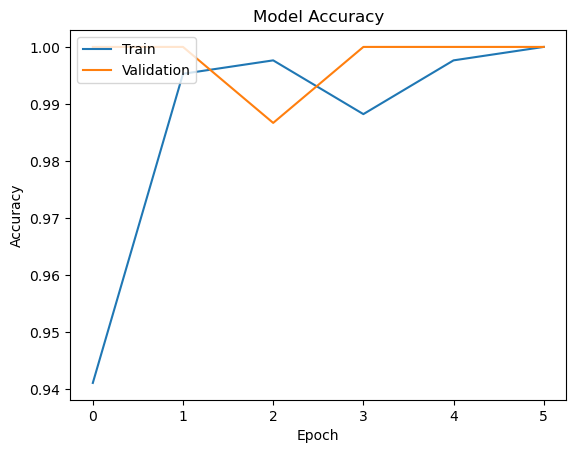

In [12]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

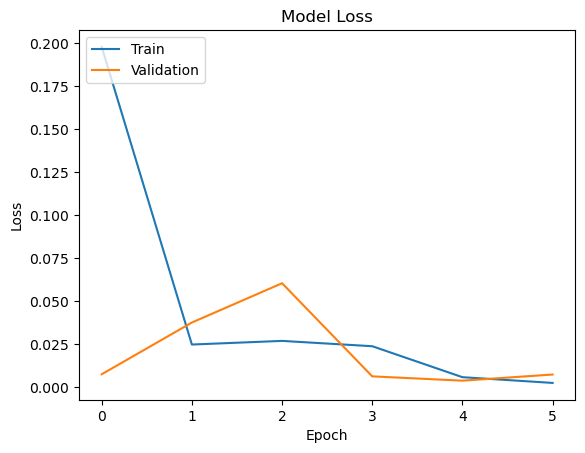

In [13]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Load the saved model
model = tf.keras.models.load_model('trained_model.h5')

# Make predictions on test data
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
if predictions[0][predicted_classes[0]] < 0.7:
    predicted_classes[0] = 1

# Define class weights
class_weights = {0: 8.1785, 1: 1}  # You can adjust the weights based on your requirements

# Convert one-hot encoded labels back to categorical labels
true_classes = np.argmax(test_labels, axis=1)

# Compute accuracy with weighted classes
accuracy = accuracy_score(true_classes, predicted_classes, sample_weight=[class_weights[c] for c in true_classes])
c_m = confusion_matrix(true_classes, predicted_classes, sample_weight=[class_weights[c] for c in true_classes])

# Showing Confusion Matrix in form of 2D Numpy array
print('confusion_matrix:',c_m)

print('Test Accuracy:', accuracy)

8/8 [==============================] - 61s 7s/step
confusion_matrix: [[228.998   0.   ]
 [  9.    218.   ]]
Test Accuracy: 0.9802630713292602
